Song, Shim, Rosenberg (2022) Large-scale neural dynamics in a shared low-dimensional state space reflect cognitive and attentional dynamics<br>
code created by: Hayoung Song (hyssong@uchicago.edu), March 27, 2022

The code generates **Figure 1 & 3** of the paper

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import random
from nilearn import datasets, surface
from nilearn.image import load_img, new_img_like
from nilearn.plotting import plot_surf_stat_map
from nilearn.surface import vol_to_surf
from matplotlib.colors import ListedColormap
random.seed(12345)

In [2]:
nstate=4
loaddir='../'
statename = ['DMN','DAN','SM','base']
condition=['rest1','rest2','gradCPTface','gradCPTscene','sitcomep1','sitcomep2','documentary']
cmap = np.array([[219 / 255, 68 / 255, 55 / 255, 1],
    [57 / 255, 0 / 255, 216 / 255, 1],
    [15 / 255, 157 / 255, 88 / 255, 1],
    [255 / 255, 215 / 255, 0 / 255, 1]])

## Mean activation (Figure 1b)

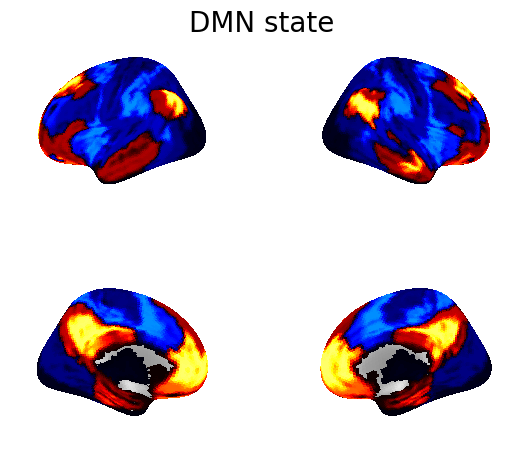

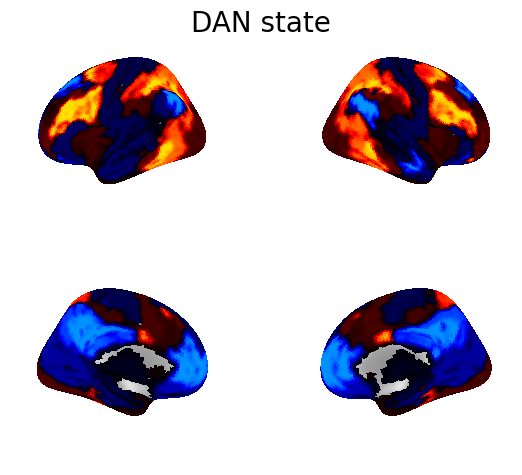

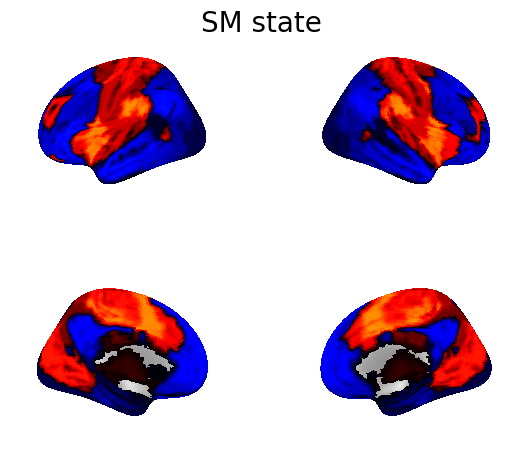

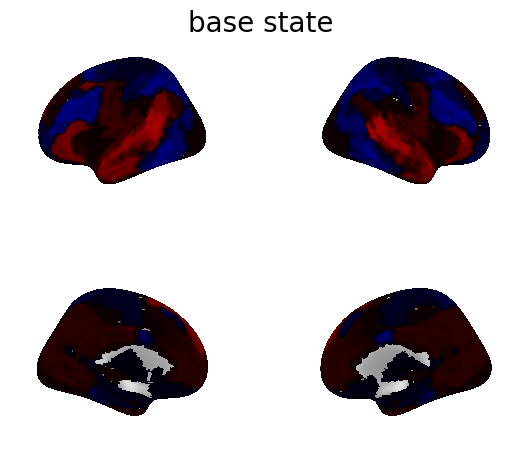

In [3]:
# reference image: MNI template
ref_img = load_img(loaddir+'fmri/MNI152_T1_3mm_brain.nii.gz')

for stt in range(1,nstate+1):
    # images are reconstructed using the HMM-inferred 25-parcel mean activity patterns of the four states
    state = load_img(loaddir+'fmri/state'+str(stt)+'_raw.nii.gz')
    state = state.dataobj[:]
    state_zmap = new_img_like(ref_img,state)

    # volume to surface reconstruction
    fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')
    surface_left = surface.vol_to_surf(state_zmap, fsaverage.pial_left)
    surface_right = surface.vol_to_surf(state_zmap, fsaverage.pial_right)

    sns.set_context('paper')
    fig, ((a, b),(c, d)) = plt.subplots(2, 2, subplot_kw={'projection': '3d'})

    plot_surf_stat_map(fsaverage.infl_left, surface_left, hemi='left',
                       view='lateral', bg_map=fsaverage.sulc_left, threshold=.0001, cmap='cold_hot',
                       vmax=1.2, symmetric_cbar=1, colorbar=False, axes=a)
    plot_surf_stat_map(fsaverage.infl_right, surface_right, hemi='right',
                       view='lateral', bg_map=fsaverage.sulc_right, threshold=.0001, cmap='cold_hot',
                       vmax=1.2, symmetric_cbar=1, colorbar=False, axes=b)
    plot_surf_stat_map(fsaverage.infl_left, surface_left, hemi='left',
                       view='medial',bg_map=fsaverage.sulc_left, threshold=.0001, cmap='cold_hot',
                       vmax=1.2, symmetric_cbar=1, colorbar=False, axes=c)
    plot_surf_stat_map(fsaverage.infl_right, surface_right, hemi='right',
                       view='medial',bg_map=fsaverage.sulc_right, threshold=.0001,cmap='cold_hot',
                       vmax=1.2, symmetric_cbar=1, colorbar=False, axes=d)
    plt.tight_layout()
    plt.suptitle(statename[stt-1]+' state', fontsize=20)

## Covariance matrix (Figure 1b)

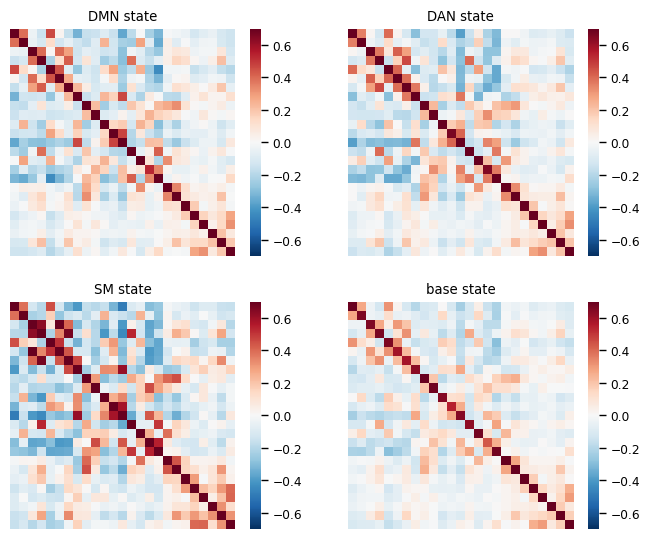

In [4]:
# Visualize HMM-inferred covariance patterns of the four states
Covars = scipy.io.loadmat(loaddir+'fmri/hmmmodel.mat')['Covars']
fig = plt.subplots(figsize=(8,6.5))
plt.subplot(221)
sns.heatmap(Covars[0,:,:],vmin=-0.7,vmax=0.7,cmap='RdBu_r',cbar=True, xticklabels=False, yticklabels=False)
plt.title('DMN state')
plt.subplot(222)
sns.heatmap(Covars[1,:,:],vmin=-0.7,vmax=0.7,cmap='RdBu_r',cbar=True, xticklabels=False, yticklabels=False)
plt.title('DAN state')
plt.subplot(223)
sns.heatmap(Covars[2,:,:],vmin=-0.7,vmax=0.7,cmap='RdBu_r',cbar=True, xticklabels=False, yticklabels=False)
plt.title('SM state')
plt.subplot(224)
sns.heatmap(Covars[3,:,:],vmin=-0.7,vmax=0.7,cmap='RdBu_r',cbar=True, xticklabels=False, yticklabels=False)
plt.title('base state')
plt.show()

## Situate latent states onto the gradient space (Figure 1d)
Top-5 gradient values of cortical and subcortical voxels are downloaded from a repository. (Margulies et al., 2016; https://identifiers.org/neurovault.collection:1598) <br>
Applying 25 parcel mask, gradient values of every voxel within each parcel are averaged. <br>
We used 17 cortical parcels of Yeo et al. (2011) liberal mask (resampled to 3mm resolution) and 8 subcortical parcels of Tian et al. (2020) S1 mask (3T, Subcortex-Only, resampled to 3mm resolution) where left and right hemisphere ROIs are collapsed as one parcel. 

In [5]:
# gradcoef: mean gradient values of 25 parcels
gradientcoeff = scipy.io.loadmat(loaddir+'fmri/gradientcoeff.mat')['gradientcoeff']
print('mean gradient values of '+str(gradientcoeff.shape[0])+' parcels, '+str(gradientcoeff.shape[1])+' components')

mean gradient values of 25 parcels, 5 components


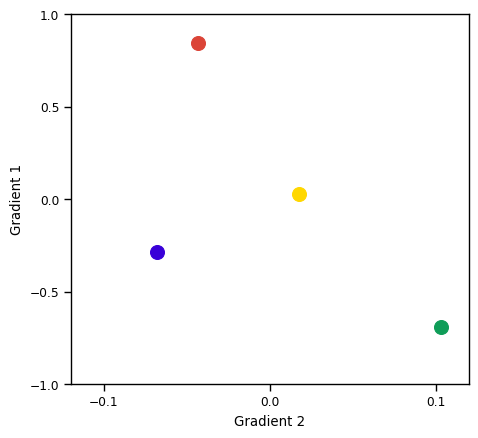

In [6]:
# Load mean activity patterns of 25 parcels inferred from the HMM fit
Means = scipy.io.loadmat(loaddir+'fmri/hmmmodel.mat')['Means']
# 4 latent state * 25 ROI mean activity patterns

# mean element-wise product of the HMM-inferred mean activity patterns and gradient coefficients
fig = plt.figure()
ax = fig.add_subplot(111)
for stt in range(nstate):
    plt.scatter(np.mean(np.multiply(Means[stt,:], gradientcoeff[:,1]))*(-1), 
                np.mean(np.multiply(Means[stt,:], gradientcoeff[:,0])),
                s=100,c=cmap[stt,:].reshape(1,-1))
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
ax.set_xlim([-0.12,0.12])
ax.set_ylim([-1,1])
ax.set_xticks([-0.1,0,0.1])
ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_ylabel('Gradient 1')
ax.set_xlabel('Gradient 2')
plt.show()

## Latent state sequence (Figure 3a)

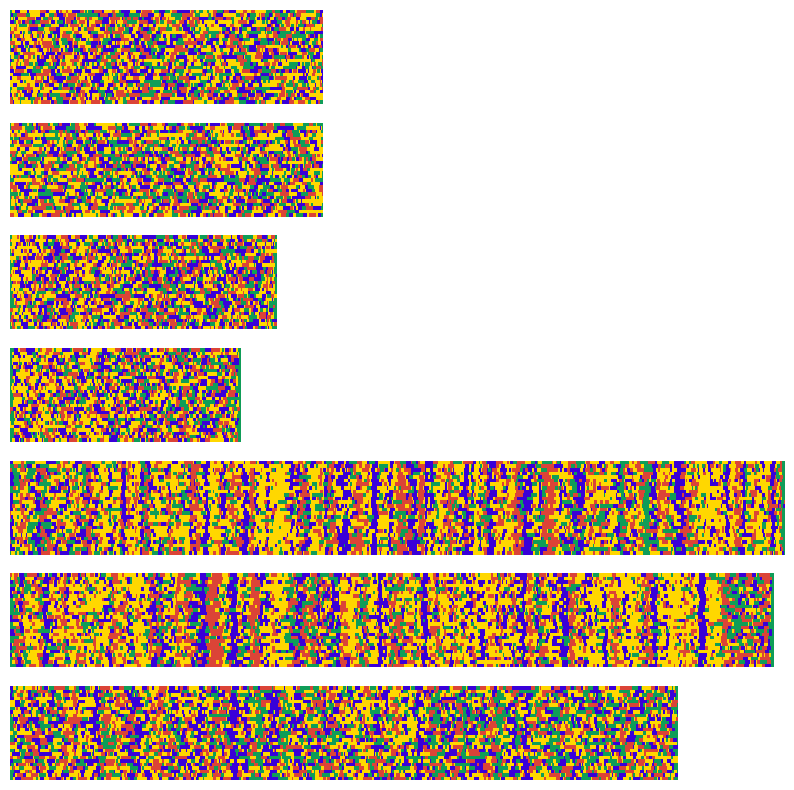

In [7]:
fig = plt.subplots(figsize=(10, 10))
for i, cdt in enumerate(condition):
    seq = scipy.io.loadmat(loaddir+'fmri/hmmoutput.mat')[cdt]
    if cdt=='sitcomep1': # missing sitcom episode 1 fMRI scan of one participant
        seq = np.delete(seq, 25,0)
    plt.subplot(7,1,i+1)
    sns.heatmap(seq, cmap=ListedColormap(cmap), cbar=False, xticklabels=False, yticklabels=False)
    plt.xlim([0,1486])

## Pairwise participant latent state similarity

In [8]:
print('Pairwise participant latent state similarity (%)')
for i, cdt in enumerate(condition):
    seq = scipy.io.loadmat(loaddir+'fmri/hmmoutput.mat')[cdt]
    if cdt=='sitcomep1':
        seq = np.delete(seq, 25,0)
    
    # compute pairwise synchrony
    pairsync = []
    for s1 in range(seq.shape[0]-1):
        for s2 in range(s1+1,seq.shape[0]):
            s1seq = seq[s1,:]
            s2seq = seq[s2,:]
            pairsync.append(np.sum(s1seq==s2seq)/len(s1seq))
    pairsync=np.asarray(pairsync)
    print(' - '+cdt+': '+str(np.round(np.mean(pairsync)*100,2))+' +/- '+str(np.round(np.std(pairsync)*100,2))+'%')

Pairwise participant latent state similarity (%)
 - rest1: 25.81 +/- 4.0%
 - rest2: 25.84 +/- 4.08%
 - gradCPTface: 27.27 +/- 4.01%
 - gradCPTscene: 28.16 +/- 3.96%
 - sitcomep1: 40.81 +/- 3.84%
 - sitcomep2: 40.79 +/- 3.27%
 - documentary: 30.39 +/- 3.38%
